In [1]:
from fastai.collab import *
from fastai.tabular import *

## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [2]:
user,item,title = 'userId','movieId','title'

In [3]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/home/paresh/.fastai/data/movie_lens_sample')

In [4]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


That's all we need to create and train a model:

In [11]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [12]:
y_range = [0,5.5]

In [13]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [14]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,1.618549,0.957047,00:01
1,0.849707,0.676712,00:00
2,0.641120,0.669625,00:00


## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [18]:
path=Config.data_path()/'ml-100k'
path

PosixPath('/home/paresh/.fastai/data/ml-100k')

In [19]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [20]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [21]:
len(ratings)

100000

In [22]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [31]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [32]:
data.show_batch()

userId,title,target
829,Titanic (1997),4.0
758,"English Patient, The (1996)",5.0
821,Courage Under Fire (1996),4.0
102,"Seventh Seal, The (Sjunde inseglet, Det) (1957)",3.0
57,Grosse Pointe Blank (1997),5.0


In [33]:
y_range = [0,5.5]

In [40]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


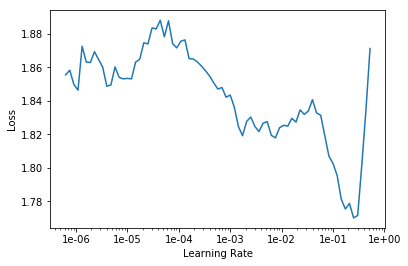

In [41]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [42]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.946398,0.939226,00:04
1,0.836589,0.883970,00:07
2,0.774303,0.838021,00:05
3,0.664144,0.817302,00:04
4,0.541663,0.816799,00:04


In [43]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [44]:
learn.load('dotprod');

In [45]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [46]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie bias

In [47]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [48]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [49]:
item0 = lambda o:o[0]

In [50]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3562),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3350),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2921), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2747), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2670), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2564), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2553), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2420), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2386), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2351), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2287), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2261), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2113), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2040), 'Home Alone 3 (1997)', 1.894736842105263),
 (tensor(-0.2034), 'Anaconda (1997)',

In [51]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.6035), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5830), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5597), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5501), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5385), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5167), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5164), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5070), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.4855), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4844), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4741), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4733), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4619), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4614), 'To Kill a Mockingbird (1962)', 4.292237442922374),
 (tensor(0.4588), 'Casablanca (1942)', 4.45679012345679)]

### Movie weights

In [52]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [53]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [54]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [55]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.0680), 'Casablanca (1942)'),
 (tensor(1.0652), 'Wrong Trousers, The (1993)'),
 (tensor(1.0620), 'Close Shave, A (1995)'),
 (tensor(1.0368), 'When We Were Kings (1996)'),
 (tensor(1.0216), 'Lawrence of Arabia (1962)'),
 (tensor(1.0056), 'Citizen Kane (1941)'),
 (tensor(0.9996), 'Third Man, The (1949)'),
 (tensor(0.9698),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(0.9684), 'Chinatown (1974)'),
 (tensor(0.9363), 'North by Northwest (1959)')]

In [56]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2885), 'Home Alone 3 (1997)'),
 (tensor(-1.2332), 'D3: The Mighty Ducks (1996)'),
 (tensor(-1.2216), 'Jungle2Jungle (1997)'),
 (tensor(-1.1996), "McHale's Navy (1997)"),
 (tensor(-1.1468), 'Leave It to Beaver (1997)'),
 (tensor(-1.1164), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.0904), 'Congo (1995)'),
 (tensor(-1.0621), 'Batman & Robin (1997)'),
 (tensor(-1.0252), 'Bio-Dome (1996)'),
 (tensor(-1.0037), 'Grease 2 (1982)')]

In [57]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [58]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1432), 'Braveheart (1995)'),
 (tensor(1.0728), 'Raiders of the Lost Ark (1981)'),
 (tensor(1.0544), 'Titanic (1997)'),
 (tensor(0.8939), 'Forrest Gump (1994)'),
 (tensor(0.8927), 'Independence Day (ID4) (1996)'),
 (tensor(0.8550), 'American President, The (1995)'),
 (tensor(0.8523), 'Back to the Future (1985)'),
 (tensor(0.8296), "Mr. Holland's Opus (1995)"),
 (tensor(0.8252), 'Return of the Jedi (1983)'),
 (tensor(0.8221), 'Pretty Woman (1990)')]

In [59]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.9398), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(-0.8559), 'Keys to Tulsa (1997)'),
 (tensor(-0.8445), 'Trainspotting (1996)'),
 (tensor(-0.8192), 'Clockwork Orange, A (1971)'),
 (tensor(-0.7481), 'Cable Guy, The (1996)'),
 (tensor(-0.7455), 'Stuart Saves His Family (1995)'),
 (tensor(-0.7424), 'Crumb (1994)'),
 (tensor(-0.7281), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(-0.7281), 'Dead Man (1995)'),
 (tensor(-0.7198), 'Stupids, The (1996)')]

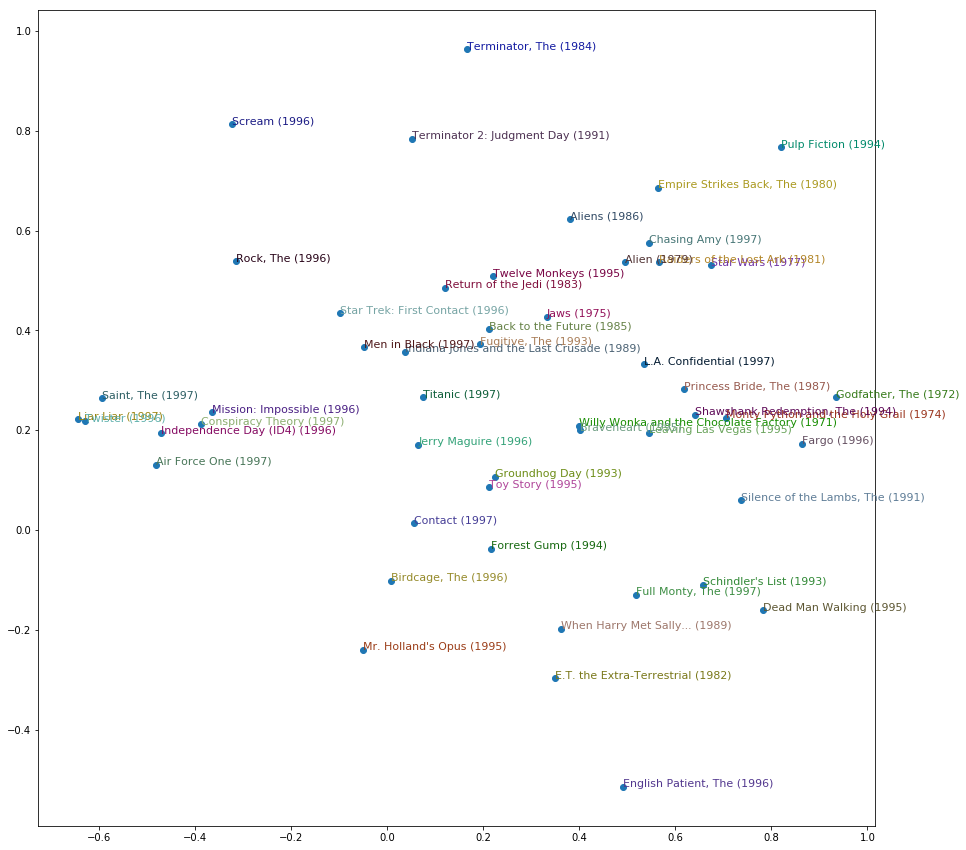

In [60]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()